In [37]:
####################################################################################################
# CR.Composite.ipynb
# Karl Lapo August/2015
####################################################################################################
# Composites of annual cycle, motivation for indexing 
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
from scipy import interpolate as interp
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'
dir_AN = '/aeronet'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [2]:
####################################################################################################
# Functions
####################################################################################################

In [3]:
#### Function for combining xray data variables into a single array with new labeled dimension
def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
    ds_out = xray.Dataset()
    ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
    ds_out = ds_out.rename({'new_dim': new_dim_name})
    ds_out.coords[new_dim_name] = dat_vars
    ds_out.name = combinevarname

    return ds_out

In [4]:
####################################################################################################
# Format Data
####################################################################################################

In [5]:
##### Load daily data

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.daily.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})
nldas.SWdwn.values[nldas.SWdwn.values > 2000] = np.nan

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.daily.nc')
############ No flipping -- SYN reformatted on 08/20/15 for CR.Composite. OTHER SCRIPTS WILL NEED THIS FIX

#########
## VIC ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.daily.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.daily.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

In [6]:
##### Process daily ground observations
os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
grobs = grobs.resample(freq='D', dim='time', how='mean')
grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
grobs.longitude.values = -grobs.longitude.values

## Remove stations outside study domain
# Bounding box - ragged domain
LL_rag = [-120,34.5]
LR_rag = [-115,34.5]
UR_rag = [-118.5,41]
UL_rag = [-123.5,41]

# Station lat/lon
stat_lat = grobs.latitude.values
stat_lon = grobs.longitude.values

# Ragged domain, CA study area
line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
# Reindex
stat_to_keep = grobs.station[ind]
grobs = grobs.reindex(station=stat_to_keep)

## Append station group information
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})    
# Merge into ground observation structure
grobs = grobs.merge(stdat,join='inner')
grobs = grobs.rename({'SWdwn':'grobs'})


In [7]:
#### Combine
## List w/ all irradiance datasets
daily_mean = {}
daily_mean['syn'] = syn
daily_mean['nldas'] = nldas
daily_mean['mtclim'] = mtclim
daily_mean['wrf'] = wrf
daily_mean['grobs'] = grobs

## Names
# Product names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

In [8]:
####################################################
## Find grid point containing each ground station ##
####################################################
# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

for pr in pr_names:        
    if pr == 'grobs':
        continue
    # lat/lon for product
    lon_rad = daily_mean[pr].longitude.values
    lat_rad = daily_mean[pr].latitude.values  
    # mesh
    lonm, latm = np.meshgrid(lon_rad,lat_rad)
    
    # Empty numpy array
    to_merge = np.empty((daily_mean[pr].time.size,grobs.station.size))
    
    ## Product values in each grid containing station
    for stat in grobs.station.values:
        
        # Station index
        stat_ind = np.where(stat == grobs.station.values)
        # Distance to product grid lat-lon
        d = (latm-lat_stat[stat_ind])**2 + (lonm-lon_stat[stat_ind])**2
        # Index of closest product grid
        dind = np.where(d==np.amin(d))
        # Grad grid values at the station, put into xray dataset
        if (daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]] == 0).all() \
                | np.isnan(daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]]).all():
            to_merge[:,stat_ind[0]] = daily_mean[pr].SWdwn.values[:,dind[0][0]+1,dind[1][0],np.newaxis]
        else:
            to_merge[:,stat_ind[0]] = daily_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0],np.newaxis]
    
    ## Merge products w/ grobs xray structure
    to_merge_ds = xray.Dataset({pr:(('time','station'),to_merge), \
                                    'time':daily_mean[pr].time.values,\
                                    'station':grobs.station.values})
    grobs = grobs.merge(to_merge_ds)

In [9]:
#### Elevation Angle
d = pd.to_datetime(grobs.time.values)
el = xray.Dataset()
for stat in grobs.station.values:
    el[stat] = (('time'),solargeo.AVG_EL(d,\
                     grobs.loc[{'station':stat}].latitude.values,\
                     grobs.loc[{'station':stat}].longitude.values,\
                     0,'END'))
el = combinevars(el,el.data_vars,new_dim_name='station',combinevarname='el')
el.coords['time'] = d

# Add to xray Dataset
grobs['el'] = (('station','time'),el)

In [10]:
print(grobs)

<xray.Dataset>
Dimensions:    (station: 73, time: 5753)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
  * station    (station) object 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    Grouping   (station) object 'south cv' 'foothills' 'foothills' ...
Data variables:
    grobs      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    mtclim     (time, station) float64 113.1 69.73 94.44 114.6 113.9 110.2 ...
    nldas      (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    syn        (time, station) float64 nan nan nan nan nan nan nan nan nan ...
    wrf        (time, station) float64 nan nan nan nan nan nan 

In [22]:
####################################################################################################
# Composites
####################################################################################################

In [13]:
#### General attributes
## Plotting set-up
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

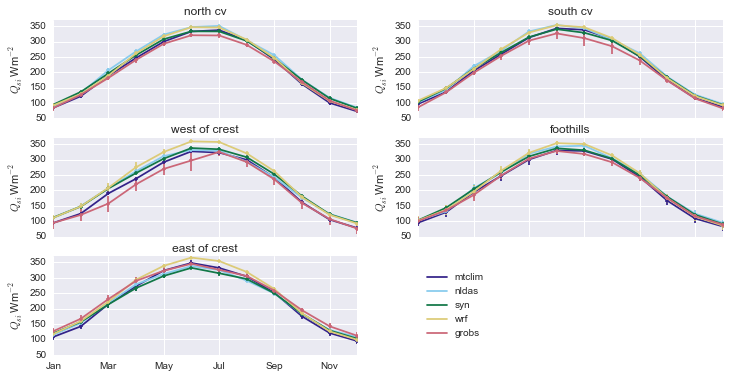

In [14]:
#### Monthly composite of annual cycle (Qsi)
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax,gr in zip(axes.flatten(),grouping):
    for n,pr in enumerate(pr_names_plot):
        month_comp = grobs[pr].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
    ax.set_ylim(50,370)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('$Q_{si}$ Wm$^{-2}$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')


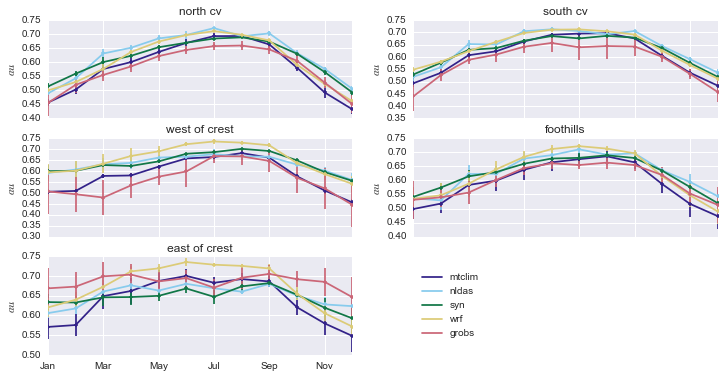

In [15]:
#### Monthly composite of annual cycle (Tau)
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tau = grobs/(np.sin(grobs.el*np.pi/180)*1365)

for ax,gr in zip(axes.flatten(),grouping):
    for n,pr in enumerate(pr_names_plot):
        month_comp = tau[pr].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
#     ax.set_ylim(50,370)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('$\tau$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')


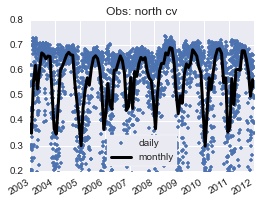

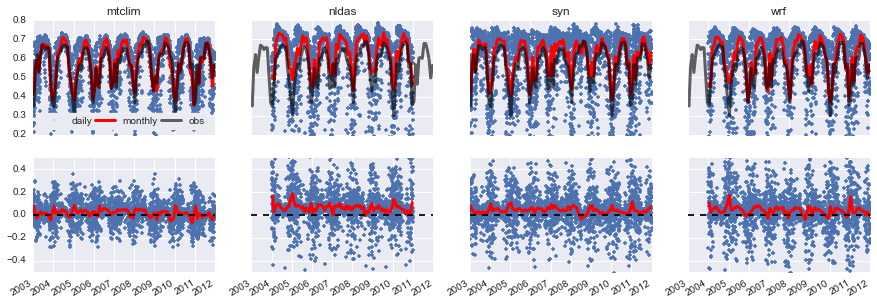

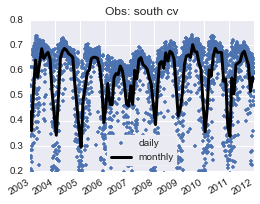

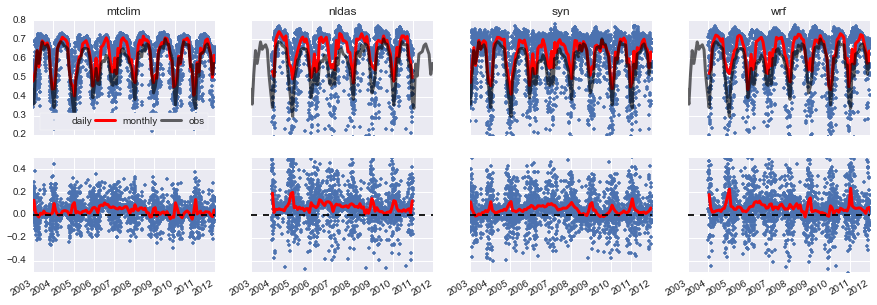

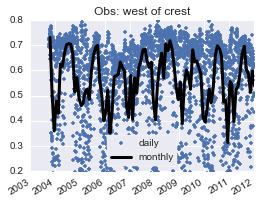

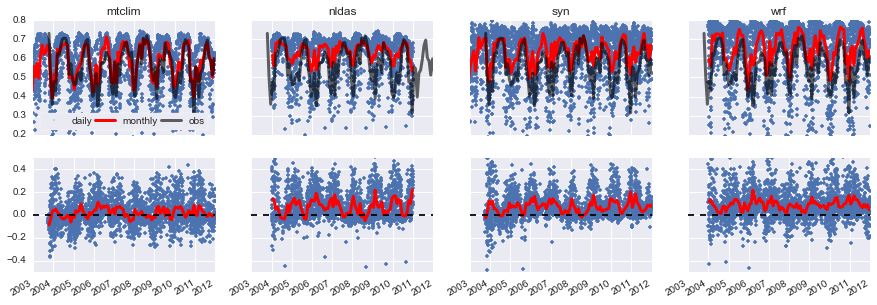

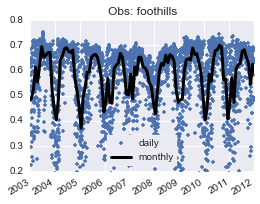

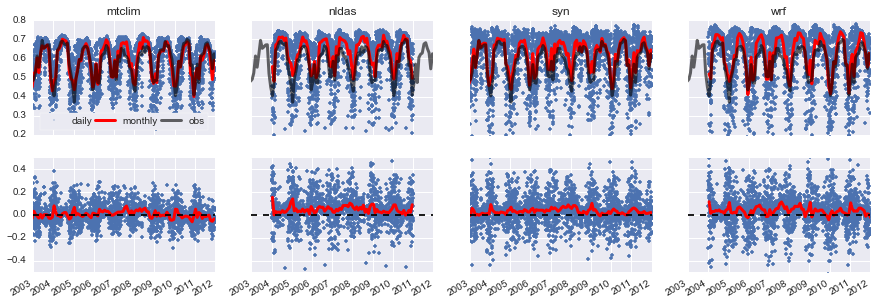

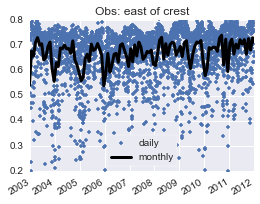

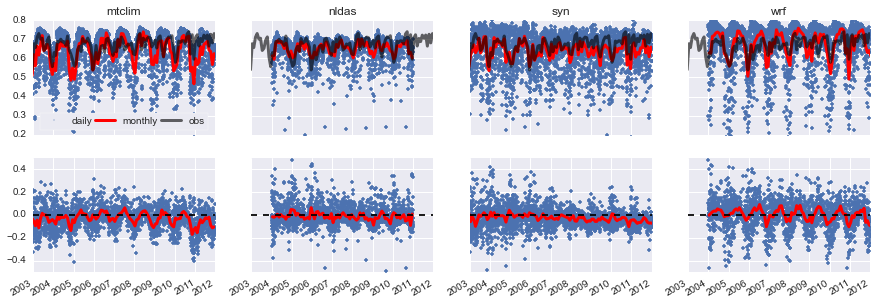

In [19]:
#### Time series: transmissivity
# Transmissivity
tau = grobs.grobs/(np.sin(grobs.el*np.pi/180)*1365)

## Transmissivity by group
for gr in grouping:
    ## tau for ground observations
    f = plt.figure(figsize=(4,3))
    tau_grobs = tau.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')

    plt.plot(tau_grobs.time,tau_grobs,'.',label='daily')
    plt.plot(tau_grobs.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='monthly')

    ax = plt.gca()
    ax.set_title('Obs: '+gr)
    ax.set_ylim(.2,.8)
    ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
    ax.legend(frameon=True,loc='best')
    f.autofmt_xdate()
    
    ## transmissivity of products
    f, axes = plt.subplots(2, num_products, figsize=(15,5),sharex='col', sharey='row')
    f.autofmt_xdate()
    for n,pr in enumerate(pr_names):
        # Mean transmissivity
        tau_pr = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)
        tau_plot = tau_pr.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        
        ax = axes[0,n]
        ax.plot(tau_pr.time,tau_plot,'.',label='daily')
        ax.plot(tau_plot.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_plot.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(tau.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='obs',alpha=.6)

        ax.set_ylim(.2,.8)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
        ax.set_title(pr)
        if ax == axes[0,0]:
            ax.legend(loc='lower center',ncol=3,frameon=True,markerscale=.3,columnspacing=.3,)

        # Difference from observed tau
        tau_diff = tau_plot-tau_grobs

        ax = axes[1,n]
        ax.plot(tau_diff.time,tau_diff,'.',label='daily')
        ax.plot(tau_diff.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_diff.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(np.array((datetime(2003,1,1),datetime(2012,1,1))),np.array((0,0)),'k--')

        ax.set_ylim(-.5,.5)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))

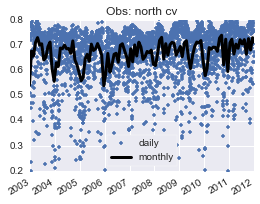

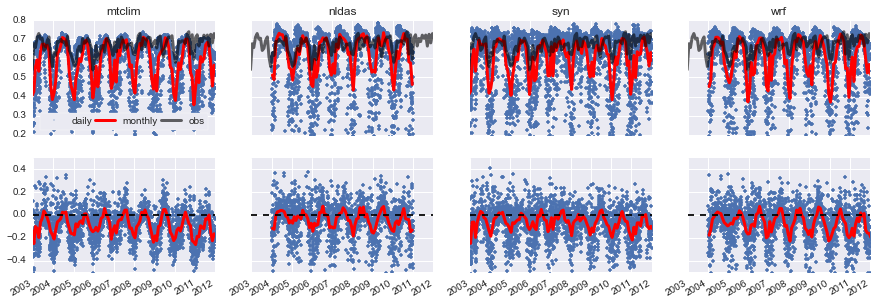

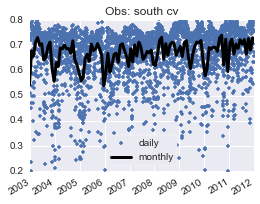

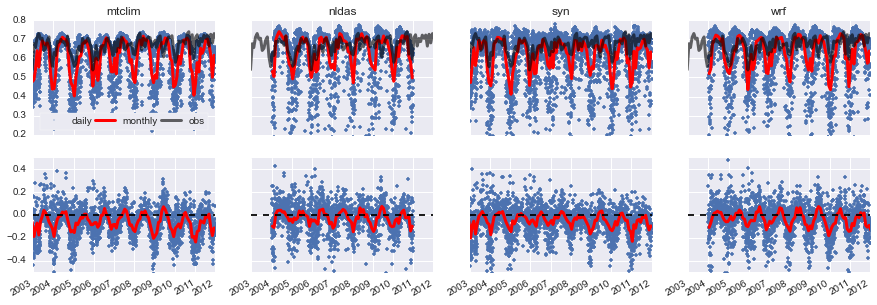

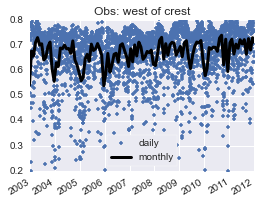

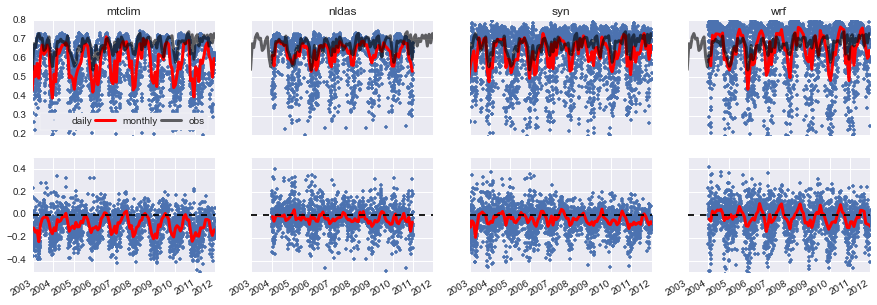

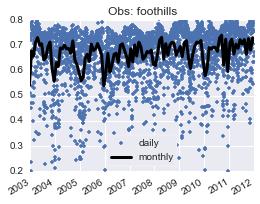

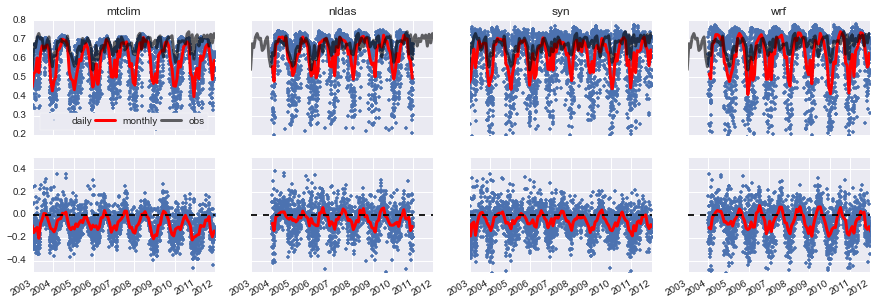

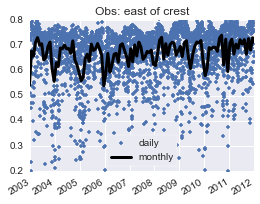

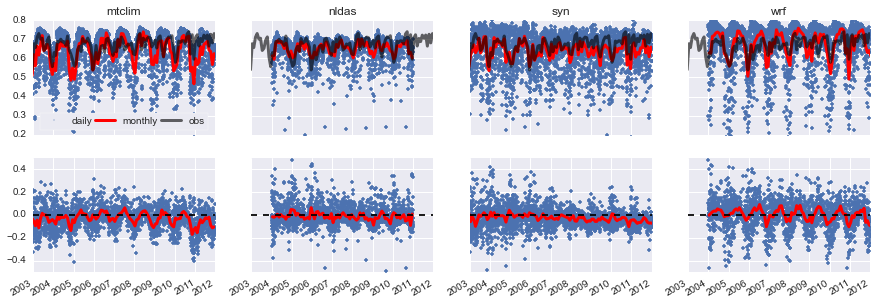

In [20]:
#### Time series: Mean group value, number of observations, anomaly
## Function for creating anomalies
def mon_anom(xray_ds,grouping_var,groups):
    # Time averaging -- monthly averaging regardless of daily or monthly anomalies?
    month_group = xray_ds.groupby('time.month')

    # Monthly mean composite mean/standard deviation
    comp_mean = month_group.mean('time')
    comp_std = month_group.std('time')

    # For each group, find mean monthly anomaly 
    anom = xray.Dataset()

    # Anomaly
    if period == 'month':
        anom['mean'] = xray_ds.groupby('time.month') - comp_mean
        anom['std'] = xray_ds.resample(freq='M', dim='time', how='std')
    return anom    
    
    tau_grobs = tau.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    # Monthly anomaly maps
    df_anom = xray_df.groupby('time.month')-df_cl

    # Return anomaly/index
    return(anomaly)

#### Time series: transmissivity
# Transmissivity
tau = grobs.grobs/(np.sin(grobs.el*np.pi/180)*1365)

## Transmissivity by group
for gr in grouping:
    ## tau for ground observations
    f = plt.figure(figsize=(4,3))

    plt.plot(tau_grobs.time,tau_grobs,'.',label='daily')
    plt.plot(tau_grobs.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='monthly')

    ax = plt.gca()
    ax.set_title('Obs: '+gr)
    ax.set_ylim(.2,.8)
    ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
    ax.legend(frameon=True,loc='best')
    f.autofmt_xdate()
    
    ## transmissivity of products
    f, axes = plt.subplots(2, num_products, figsize=(15,5),sharex='col', sharey='row')
    f.autofmt_xdate()
    for n,pr in enumerate(pr_names):
        # Mean transmissivity
        tau_pr = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)
        tau_plot = tau_pr.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        
        ax = axes[0,n]
        ax.plot(tau_pr.time,tau_plot,'.',label='daily')
        ax.plot(tau_plot.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_plot.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(tau.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='obs',alpha=.6)

        ax.set_ylim(.2,.8)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))
        ax.set_title(pr)
        if ax == axes[0,0]:
            ax.legend(loc='lower center',ncol=3,frameon=True,markerscale=.3,columnspacing=.3,)

        # Difference from observed tau
        tau_diff = tau_plot-tau_grobs

        ax = axes[1,n]
        ax.plot(tau_diff.time,tau_diff,'.',label='daily')
        ax.plot(tau_diff.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_diff.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(np.array((datetime(2003,1,1),datetime(2012,1,1))),np.array((0,0)),'k--')

        ax.set_ylim(-.5,.5)
        ax.set_xlim(datetime(2003,1,1),datetime(2012,1,1))



In [24]:
#### Function for creating anomalies by group
def mon_anom(ds_in,grouping_var,groups,var,period):
    # Initialize output Dataset
    anom = xray.Dataset()

    # Aggregate grouping variables
    group_ds = group_mean(ds_in,grouping_var,groups)
    group_ds = combinevars(group_ds,groups,new_dim_name=grouping_var,combinevarname=var)

    # Time averaging -- monthly averaging regardless of daily or monthly anomalies?
    # Monthly mean composite
    comp_mean = group_ds.groupby('time.month').mean('time')

    # For each group, find mean monthly anomaly 
    if period == 'month':
        anom['mean'] = group_ds.groupby('time.month') - comp_mean
        anom['std'] = group_ds.resample(freq='M', dim='time', how='std')
    elif period == 'day':
        anom['mean'] = group_ds.groupby('time.day') - comp_mean
        anom['std'] = group_ds.resample(freq='D', dim='time', how='std')

    return anom
    
#### Function taking mean across grouping variable, leaving other dimensions untouched
def group_mean(ds_in,grouping_var,groups):
    gr_ds = xray.Dataset()
    for gr in groups:
        gr_ds[gr] = ds_in.loc[{grouping_var:gr}].mean(grouping_var)
    return(gr_ds)
    
#### Function for combining xray data variables into a single array with new labeled dimension
def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
    ds_out = xray.Dataset()
    ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
    ds_out = ds_out.rename({'new_dim': new_dim_name})
    ds_out.coords[new_dim_name] = dat_vars
    ds_out.name = combinevarname

    return ds_out

ds_in = tau.swap_dims({'station':'Grouping'})
groups = ['north cv','south cv','west of crest','foothills','east of crest']
grouping_var = 'Grouping'
var = 'tau'
period = 'month'

anom = mon_anom(ds_in,grouping_var,groups,var,period)
print(anom)

<xray.Dataset>
Dimensions:   (Grouping: 5, time: 5753)
Coordinates:
  * Grouping  (Grouping) |S13 'north cv' 'south cv' 'west of crest' ...
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    month     (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    mean      (Grouping, time) float64 nan nan nan nan nan nan nan nan nan ...
    std       (Grouping, time) float64 nan nan nan nan nan nan nan nan nan ...


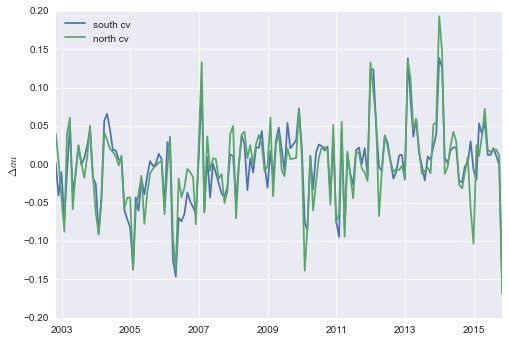

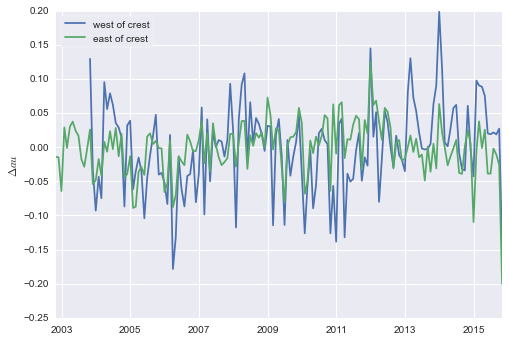

In [99]:
#### Time series of monthly anomaly in Tau - North vs South
groups_for_plot = ['south cv','north cv']
time_month = anom.resample(freq='M',dim='time',how='mean').time
for n,gr in enumerate(groups_for_plot):
    plt.plot(time_month,anom['mean'].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],label=gr)
ax = plt.gca()
ax.legend(frameon=True,loc='best')
ax.set_ylabel('$\Delta \tau$')

#### Time series of monthly anomaly in Tau - East vs West
plt.figure()
groups_for_plot = ['west of crest','east of crest']
time_month = anom.resample(freq='M',dim='time',how='mean').time
for n,gr in enumerate(groups_for_plot):
    plt.plot(time_month,anom['mean'].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],label=gr)
ax = plt.gca()
ax.legend(frameon=True,loc='best')
ax.set_ylabel('$\Delta \tau$')


In [25]:
#### Mean bias for each group
## Bias
grobs_diff = xray.Dataset()
for pr in pr_names:
    grdiff = grobs[pr]-grobs['grobs']
    ## Mean for each group
    grdiff = group_mean(grdiff.swap_dims({'station':'Grouping'}),grouping_var,groups)
    grobs_diff[pr] = combinevars(grdiff,groups,new_dim_name='Grouping',combinevarname=pr)

print(grobs_diff)

<xray.Dataset>
Dimensions:   (Grouping: 5, time: 5753)
Coordinates:
  * Grouping  (Grouping) |S13 'north cv' 'south cv' 'west of crest' ...
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
Data variables:
    mtclim    (Grouping, time) float64 nan nan nan nan nan nan nan nan nan ...
    nldas     (Grouping, time) float64 nan nan nan nan nan nan nan nan nan ...
    syn       (Grouping, time) float64 nan nan nan nan nan nan nan nan nan ...
    wrf       (Grouping, time) float64 nan nan nan nan nan nan nan nan nan ...


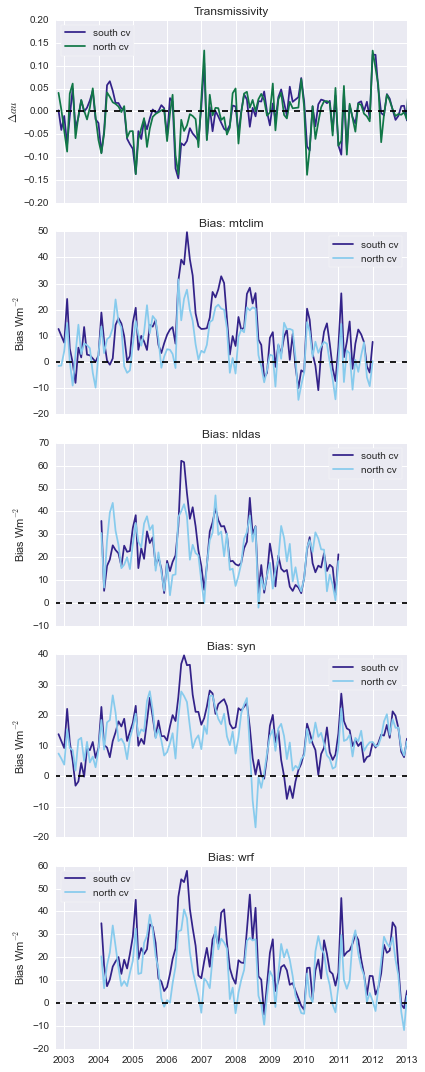

In [33]:
## Time series plot
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

f,axes = plt.subplots(num_products+1,1,figsize=(6,15),sharex=True)
groups_for_plot = ['south cv','north cv']
time_month = anom.resample(freq='M',dim='time',how='mean').time

ax = axes[0]
for n,gr in enumerate(groups_for_plot):
#     ax.plot(anom.time,anom['mean'].loc[{'Grouping':gr}],'.',color=colsche[n],label=gr+' (daily)')
    ax.plot(time_month,anom['mean'].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
             color=colsche[2*n],label=gr)
ax.legend(frameon=True,loc='best')
ax.set_ylabel('$\Delta \tau$')
ax.set_title('Transmissivity')
ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))


for m,pr in enumerate(pr_names):
    ax = axes[m+1]
    for n,gr in enumerate(groups_for_plot):
    #     ax.plot(grobs_diff.time,grobs_diff[pr].loc[{'Grouping':gr}],'.',color=colsche[2*n],label=gr+' (daily)')
        ax.plot(time_month,grobs_diff[pr].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                color=colsche[n],label=gr)
    ax.legend(frameon=True,loc='best')
    ax.set_ylabel('Bias Wm$^{-2}$')
    ax.set_title('Bias: '+pr)
    ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
    ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))

plt.tight_layout()

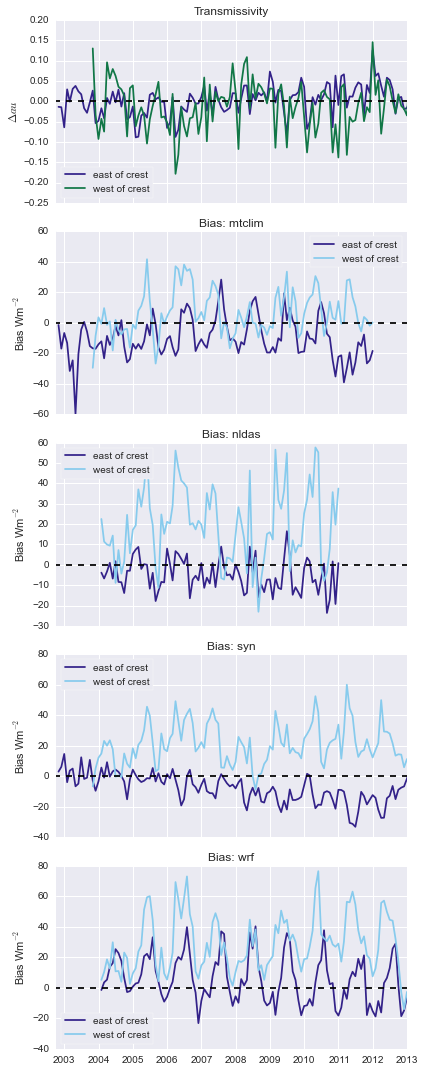

In [34]:
## Time series plot
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

f,axes = plt.subplots(num_products+1,1,figsize=(6,15),sharex=True)
groups_for_plot = ['east of crest','west of crest']
time_month = anom.resample(freq='M',dim='time',how='mean').time

ax = axes[0]
for n,gr in enumerate(groups_for_plot):
#     ax.plot(anom.time,anom['mean'].loc[{'Grouping':gr}],'.',color=colsche[n],label=gr+' (daily)')
    ax.plot(time_month,anom['mean'].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
             color=colsche[2*n],label=gr)
ax.legend(frameon=True,loc='best')
ax.set_ylabel('$\Delta \tau$')
ax.set_title('Transmissivity')
ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))

for m,pr in enumerate(pr_names):
    ax = axes[m+1]
    for n,gr in enumerate(groups_for_plot):
    #     ax.plot(grobs_diff.time,grobs_diff[pr].loc[{'Grouping':gr}],'.',color=colsche[2*n],label=gr+' (daily)')
        ax.plot(time_month,grobs_diff[pr].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                color=colsche[n],label=gr)
    ax.legend(frameon=True,loc='best')
    ax.set_ylabel('Bias Wm$^{-2}$')
    ax.set_title('Bias: '+pr)
    ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
    ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))
    
plt.tight_layout()

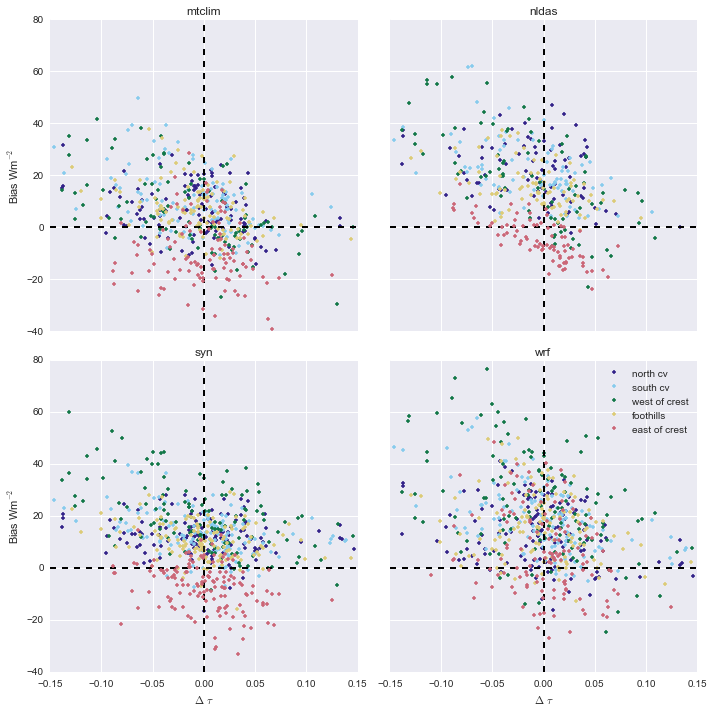

In [147]:
## Scatter plot
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

# groups_for_plot = ['south cv','north cv']
# groups_for_plot = ['south cv']
groups_for_plot = groups

f,axes = plt.subplots(2,2,figsize=(10,10),sharex='col',sharey='row')
axes = axes.flatten()
for m,pr in enumerate(pr_names):
    ax = axes[m]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(np.array((-.15,.15)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-40,80)),'k--')
        ax.plot(anom['mean'].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                grobs_diff[pr].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                '.',color=colsche[n],label=gr)
    if np.mod(m,2) == 0:
        ax.set_ylabel('Bias Wm$^{-2}$')
    if m > 1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr)
    ax.set_ylim(-40,80)
    ax.set_xlim(-.15,.15)

ax.legend()
plt.tight_layout()

In [123]:
#### Daily anomaly
def mon_anom(ds_in,grouping_var,groups,var,period):
    ## Helper function for creating extrapolated values (linear)
    # http://stackoverflow.com/questions/2745329/...
    # ...how-to-make-scipy-interpolate-give-an-extrapolated-result-beyond-the-input-range
    def extrap1d(interpolator):
        from scipy import array
        xs = interpolator.x
        ys = interpolator.y

        def pointwise(x):
            if x < xs[0]:
                return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
            elif x > xs[-1]:
                return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
            else:
                return interpolator(x)

        def ufunclike(xs):
            return array(map(pointwise, array(xs)))

        return ufunclike

    ## Group anomalies
    # Initialize output Dataset
    anom = xray.Dataset()

    ## Aggregate grouping variables
    group_ds = group_mean(ds_in,grouping_var,groups)
    group_ds = combinevars(group_ds,groups,new_dim_name=grouping_var,combinevarname=var)

    # Time averaging -- monthly averaging
    # Monthly mean composite
    comp_mean = group_ds.groupby('time.month').mean('time')

    ## Monthly, mean anomaly 
    if period == 'month':
        anom['mean'] = group_ds.groupby('time.month') - comp_mean
        anom['std'] = group_ds.resample(freq='M', dim='time', how='std')
    
    ## Daily, mean anomaly -- interpolate monthly composite
    elif period == 'day':
        # Daily composite mean calculated from interpolation of monthly composite mean
        x_day = group_ds['time.dayofyear'].values
        comp_mean_daily = xray.Dataset()
        # Julian day of month mid point for non-leap year. Force the function to be cyclic
        x_month = np.array([0,15.5, 45, 74.5, 105, 135.5, 166, 196.5, 227.5, 258, 288.5, 319, 349.5,365])
        
        # Daily anomaly for each group
        for n,gr in enumerate(groups):
            y = comp_mean.loc[{grouping_var:gr}].values
            y_cyclic = np.mean([y[0],y[-1]])
            y = np.insert(y,0,y_cyclic)
            y = np.append(y,y_cyclic)
            # Interpolation function of monthly composite
            daily_interp_f = interpolate.interp1d(x_month,y)
            # Linear extrapolation for beginning and end of year
            daily_interp_f = extrap1d(daily_interp_f)
            # Assign to structure
            comp_mean_daily[gr] = (('dayofyear'),daily_interp_f(x_day))

        # Fill out coords
        comp_mean_daily.coords['dayofyear'] = group_ds['time.dayofyear']
        comp_mean_daily = combinevars(comp_mean_daily,groups,new_dim_name=grouping_var,combinevarname=var)
        anom['anom_mean'] = group_ds.groupby('time.dayofyear') - comp_mean_daily
        
        # This needs to be changed to day of year grouping if it is to be used
#         anom['std'] = group_ds.resample(freq='D', dim='time', how='std')
    return anom

ds_in = tau.swap_dims({'station':'Grouping'})
groups = ['north cv','south cv','west of crest','foothills','east of crest']
grouping_var = 'Grouping'
var = 'tau'
period = 'day'

anom = mon_anom(ds_in,grouping_var,groups,var,period)

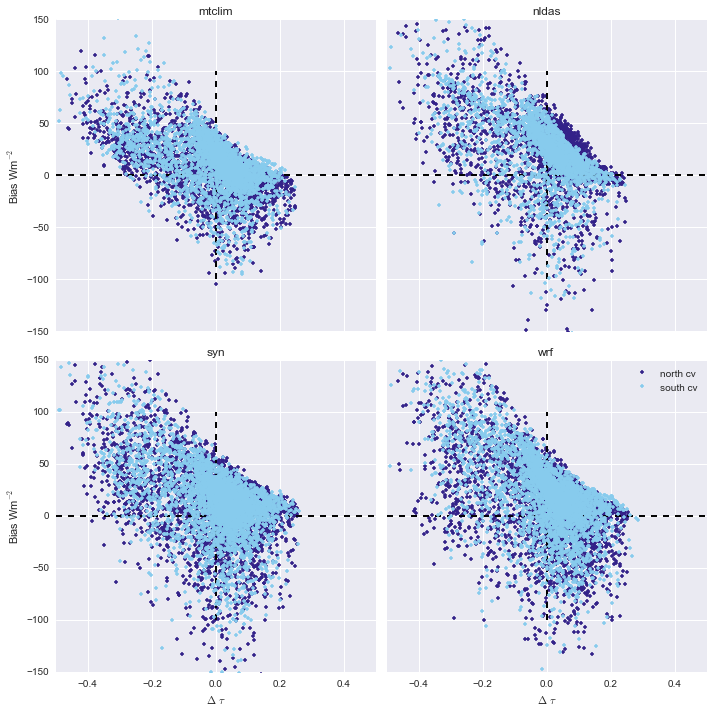

In [129]:
## Daily anomaly vs bias (scatter plot)
# groups_for_plot = groups
# groups_for_plot = ['east of crest','west of crest']
groups_for_plot = ['north cv','south cv']

f,axes = plt.subplots(2,2,figsize=(10,10),sharex='col',sharey='row')
axes = axes.flatten()
for m,pr in enumerate(pr_names):
    ax = axes[m]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(np.array((-.5,.5)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-100,100)),'k--')
        ax.plot(anom['anom_mean'].loc[{'Grouping':gr}],\
                grobs_diff[pr].loc[{'Grouping':gr}],\
                '.',color=colsche[n],label=gr)
    if np.mod(m,2) == 0:
        ax.set_ylabel('Bias Wm$^{-2}$')
    if m > 1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr)
    ax.set_ylim(-150,150)
    ax.set_xlim(-.5,.5)

ax.legend()
plt.tight_layout()